In [194]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchinfo
from torch.types import Tensor
from torchvision import models


In [2]:
class YOLOv2(nn.Module):
    def __init__(self, B: int, C: int) -> None:
        super(YOLOv2, self).__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.backbone = nn.ModuleDict(dict(self.backbone.named_children()))

        self.backbone.pop("avgpool")
        self.backbone.pop("fc")

        self.neck = nn.ModuleDict(
            {
                "layer1": nn.Sequential(
                    nn.LazyConv2d(1024, kernel_size=3, padding=1, bias=False),
                    nn.BatchNorm2d(1024),
                    nn.LeakyReLU(0.1),
                ),
                "layer2": nn.Sequential(
                    nn.Conv2d(1024, 1024, kernel_size=3, padding=1, bias=False),
                    nn.BatchNorm2d(1024),
                    nn.LeakyReLU(0.1),
                ),
                "layer3": nn.Sequential(
                    nn.LazyConv2d(1024, kernel_size=3, padding=1, bias=False),
                    nn.BatchNorm2d(1024),
                    nn.LeakyReLU(0.1),
                ),
            }
        )

        self.head = nn.Conv2d(1024, B * (5 + C), kernel_size=1)

    def forward(self, x: Tensor) -> Tensor:
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)

        x_fine_grained = self.backbone.layer3(x)
        x_full = self.backbone.layer4(x_fine_grained)

        x_full = self.neck.layer1(x_full)
        x_full = self.neck.layer2(x_full)

        batch_size = x_fine_grained.size(0)
        spatial_size = (x_fine_grained.size(2) // 2, x_fine_grained.size(3) // 2)
        x_fine_grained = x_fine_grained.view(batch_size, -1, *spatial_size)

        x_cat = torch.cat((x_fine_grained, x_full), dim=1)

        x_cat = self.neck.layer3(x_cat)
        x_cat = self.head(x_cat)

        return x_cat


B = 5
C = 20

model = YOLOv2(B=B, C=C)
x = torch.randn(1, 3, 416, 416)
out = model(x)
out.shape


torch.Size([1, 125, 13, 13])

In [3]:
from torchviz import make_dot

make_dot(out, params=dict(list(model.named_parameters()))).render("yolov2", format="png")

'yolov2.png'

In [4]:
torchinfo.summary(model, input_size=(1, 3, 448, 448))

Layer (type:depth-idx)                        Output Shape              Param #
YOLOv2                                        [1, 125, 14, 14]          --
├─ModuleDict: 1-1                             --                        --
│    └─Conv2d: 2-1                            [1, 64, 224, 224]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 224, 224]         128
│    └─ReLU: 2-3                              [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-4                         [1, 64, 112, 112]         --
│    └─Sequential: 2-5                        [1, 64, 112, 112]         --
│    │    └─BasicBlock: 3-1                   [1, 64, 112, 112]         73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 112, 112]         73,984
│    └─Sequential: 2-6                        [1, 128, 56, 56]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 56, 56]          230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 56, 56]          295,42

In [195]:
# Width and height of anchor boxes - normalized by image size.
anchor_bboxes = torch.from_numpy(np.load("./checkpoints/anchor_bboxes_k_5.npy"))
anchor_bboxes

tensor([[0.0909, 0.1513],
        [0.2128, 0.3505],
        [0.3453, 0.6833],
        [0.7909, 0.8212],
        [0.6200, 0.4043]], dtype=torch.float64)

In [286]:
from cvnets.yolov2 import utils
from cvnets.yolov2.voc import VOCDataset

dataset = VOCDataset("~/Documents/Datasets/VOC/", anchor_bboxes=anchor_bboxes, imgsz=320, split="val", normalize=False)

(416, 416, 3)


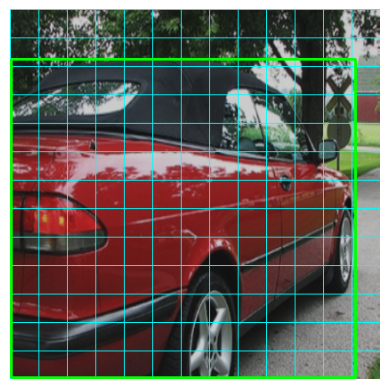

In [304]:
dataset.train()
dataset.imgsz = 416

imgsz = dataset.imgsz
S = dataset.S
B = dataset.B

sample = dataset[1]

image = sample.image.permute(1, 2, 0).numpy().astype("uint8")
bboxes = sample.bboxes
labels = sample.labels
target = sample.target

cell_size = imgsz // S
for i in range(S):
    for j in range(S):
        cv.rectangle(
            image, (j * cell_size, i * cell_size), ((j + 1) * cell_size, (i + 1) * cell_size), (0, 255, 255), 1
        )

for bbox in bboxes:
    cv.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)

print(image.shape)
plt.imshow(image)
plt.axis("off")
plt.show()

In [302]:
bboxes

tensor([[  0.4913, 104.1829, 296.4531, 430.5274]])

In [303]:
target.shape

torch.Size([16, 16, 5, 25])

In [287]:
target[4, 4]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.2840,  0.2696, -0.0319, -0.0702,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000

In [297]:
decoded = utils.decode_target(target, anchor_bboxes, S, imgsz)
decoded[4, 4]

tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000],
        [ 51.2940,  50.8911, 222.8813, 222.3640,   1.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   1.0000,  